In [1]:
import math
import multiprocessing as mp
import random
import time
from typing import Dict
from typing import Tuple
from typing import List

import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import torch
torch.set_printoptions(precision = 1)

import leabra7 as lb

%matplotlib inline

/home/noam/anaconda3/envs/leabra7/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
ThetaTrough = lb.Phase("theta_trough", "minus")
ThetaPeak = lb.Phase("theta_peak", "minus")
ThetaPlus = lb.Phase("theta_plus", "plus")
TestPhase = lb.Phase("test", "minus")

In [3]:
## Define Layer Specs

# Generic Layer Spec
layer_spec = lb.LayerSpec()

# EC Layer Spec
EC_layer_spec = lb.LayerSpec(
    inhibition_type = "kwta",
    kwta_pct = 0.25,
    kwta_pt = 0.5,
)

# DG Layer Spec
DG_layer_spec = lb.LayerSpec(
    inhibition_type = "kwta_avg",
    kwta_pct = 0.01,
    kwta_pt = 0.9,
)

# CA3 Layer Spec
CA3_layer_spec = lb.LayerSpec(
    inhibition_type = "kwta_avg",
    kwta_pct = 0.06,
    kwta_pt = 0.7,
)

# CA1 Layer Spec
CA1_layer_spec = lb.LayerSpec(
    inhibition_type = "kwta_avg",
    kwta_pct = 0.25,
    kwta_pt = 0.7,
)

In [4]:
## Define Projections Spec

# Input -> EC_in
Input_projn_spec = lb.ProjnSpec(
    dist=lb.Uniform(low=0.25, high=0.75),
    lrate = 0,
    projn_type = "one_to_one",
    minus_phase = lb.NonePhase,
    plus_phase = ThetaPlus,
)

# EC_in -> DG
# EC_in -> CA3
EC_in_projn_spec = lb.ProjnSpec(
    dist=lb.Uniform(low=0.25, high=0.75),
    lrate = 0.2,
    sparsity = 0.25,
    minus_phase = lb.NonePhase,
    plus_phase = ThetaPlus,
)

# DG -> CA3 (Mossy Fiber)
DG_CA3_projn_spec = lb.ProjnSpec(
    dist=lb.Uniform(low=0.89, high=0.91),
    wt_scale_rel = 8.0,
    sparsity = 0.05,
    lrate = 0,
    minus_phase = lb.NonePhase,
    plus_phase = ThetaPlus,
)

# CA3 -> CA3
CA3_CA3_projn_spec = lb.ProjnSpec(
    dist=lb.Uniform(low=0.25, high=0.75),
    lrate = 0.2,
    minus_phase = lb.NonePhase,
    plus_phase = ThetaPlus,
)

# CA3 -> CA1 (Schaffer)
CA3_CA1_projn_spec = lb.ProjnSpec(
    dist=lb.Uniform(low=0.25, high=0.75),
    lrate = 0.05,
    minus_phase = ThetaPeak,
    plus_phase = ThetaPlus,
)

# EC_in -> CA1 Projection Spec
EC_in_CA1_projn_spec = lb.ProjnSpec(
    dist=lb.Uniform(low=0.25, high=0.75),
    wt_scale_abs = 3.0,
    lrate = 0.02,
    minus_phase = ThetaTrough,
    plus_phase = ThetaPlus,
)

# EC_out <--> CA1 Projection Spec
EC_out_CA1_projn_spec = lb.ProjnSpec(
    dist=lb.Uniform(low=0.25, high=0.75),
    lrate = 0.02,
    minus_phase = ThetaTrough,
    plus_phase = ThetaPlus,
)

# EC_out -> EC_in Projection Spec
EC_out_EC_in_projn_spec = lb.ProjnSpec(
    dist=lb.Uniform(low=0.49, high=0.51),
    lrate = 0,
    wt_scale_abs = 2.0,
    wt_scale_rel = 0.5,
    projn_type = "one_to_one",
    minus_phase = lb.NonePhase,
    plus_phase = ThetaPlus,
)

In [5]:
def gen_net() -> lb.Net:
    # Create the Network
    net = lb.Net()

    ## Create Layers

    # Create input and output layers
    net.new_layer("Input", 8, layer_spec)
    net.new_layer("EC_in", 8, EC_layer_spec)
    net.new_layer("EC_out", 8, EC_layer_spec)

    # Create cortical layers
    net.new_layer("CA1", 100, CA1_layer_spec)
    net.new_layer("CA3", 80, CA3_layer_spec)

    # Create hippocampus
    net.new_layer("DG", 400, DG_layer_spec)

    ## Create Projections

    # Input Feed
    net.new_projn("Input: Input -> EC_in", "Input", "EC_in", spec=Input_projn_spec)
    net.new_projn("Loop: EC_out -> EC_in", "EC_out", "EC_in", spec=EC_out_EC_in_projn_spec)

    # Create MSP
    net.new_projn("MSP: EC_in -> CA1", "EC_in", "CA1", spec=EC_in_CA1_projn_spec)
    net.new_projn("MSP: CA1 -> EC_out", "CA1", "EC_out", spec=EC_out_CA1_projn_spec)
    net.new_projn("MSP: EC_out -> CA1", "EC_out", "CA1", spec=EC_out_CA1_projn_spec)

    # Create TSP
    net.new_projn("TSP: EC_in -> DG", "EC_in", "DG", spec=EC_in_projn_spec)
    net.new_projn("TSP: EC_in -> CA3", "EC_in", "CA3", spec=EC_in_projn_spec)
    net.new_projn("TSP: DG -> CA3", "DG", "CA3", spec=DG_CA3_projn_spec)
    net.new_projn("TSP: CA3 -> CA3", "CA3", "CA3", spec=CA3_CA3_projn_spec)
    net.new_projn("TSP: CA3 -> CA1", "CA3", "CA1", spec=CA3_CA1_projn_spec)
    
    return net

In [6]:
# Function to plot data for a certain attribute for each unit of layer
def plot_by_unit(axes: List[matplotlib.axes.Axes], 
                 log: pd.DataFrame, attr: str, title: str, location: List) -> None:
    for name, group in log.groupby("unit"):
        group.plot(x="time", y=attr, ax=axes[location], 
                   title = title, label="unit " + str(name))

## Sequence Learning

In [7]:
sequence_dict = dict()
sequence_dict[0] = [1]
sequence_dict[2] = [3]
sequence_dict[4] = [5]
sequence_dict[6] = [7]

sequence_dict[1] = [2, 4, 6]
sequence_dict[3] = [0, 4, 6]
sequence_dict[5] = [0, 2, 6]
sequence_dict[7] = [0, 2, 4]

def seq_next(prev: int) -> int:
    return random.choice(sequence_dict[prev])

def tensorfy(old_num: int, new_num: int) -> torch.Tensor:
    x = torch.FloatTensor(8).zero_()
    if new_num != None:
        x[new_num] = 1
    if old_num != None:
        x[old_num] = 0.9
    return x

def gen_train_seq_epoch(epoch_len) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
    old_seed = None
    curr_seed = random.randint(0,7)
    
    inputs: List[torch.Tensor] = []
    outputs: List[torch.Tensor] = []
        
    for _ in range(epoch_len):
        inputs += [tensorfy(old_seed, curr_seed)]
        
        old_seed = curr_seed
        
        curr_seed = seq_next(old_seed)
        outputs += [tensorfy(None, curr_seed)]
    
    return inputs, outputs

def gen_train_sep_epoch(epoch_len) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
    inputs: List[torch.Tensor] = []
    outputs: List[torch.Tensor] = []
        
    for i in range(epoch_len):
        curr_seed = random.choice([0, 2, 4, 6])
        inputs += [tensorfy(None, curr_seed)]
        next_seed = seq_next(curr_seed)
        outputs += [tensorfy(None, next_seed)]
    
    return inputs, outputs

def gen_test() -> Tuple[List[torch.Tensor], List[torch.Tensor]]:    
    inputs: List[torch.Tensor] = []
    outputs: List[torch.Tensor] = []
        
    for curr_seed in range(8):
        inputs += [tensorfy(None, curr_seed)] 
        if curr_seed in {0, 2, 4, 6}:
            next_seed = seq_next(curr_seed)
        else:
            next_seed = None
        outputs += [tensorfy(None, next_seed)]
    
    return inputs, outputs

## Run Network

In [8]:
def net_snapshot(network: lb.Net) -> Dict[str, torch.Tensor]:
    act_dict: Dict[str, torch.Tensor] = dict()
        
    for name, layer in network.layers.items():
        act_dict[name] = layer.units.act
        
    return act_dict

In [9]:
def pearson_correlation(patterns: Dict[int, torch.Tensor]) -> torch.Tensor:
    dim = len(patterns.keys())
    corr_matrix = torch.FloatTensor(dim, dim).zero_()
    
    for i in range(dim):
        for j in range(i, dim):
            corr = float(pearsonr(patterns[i], patterns[j])[0])
            if math.isnan(corr):
                corr = 0.0
            corr_matrix[i, j] = corr_matrix[j, i] = corr
    
    return corr_matrix

In [10]:
def learn_trial(network: lb.Net, input_pattern = torch.Tensor, output_pattern = torch.Tensor) -> None:
    # Theta Trough
    network.clamp_layer("Input", input_pattern)
    network.uninhibit_projns("MSP: EC_in -> CA1")
    network.inhibit_projns("TSP: CA3 -> CA1", "Loop: EC_out -> EC_in")
    network.phase_cycle(ThetaTrough, num_cycles = 20)
    # Theta Peak
    network.uninhibit_projns("TSP: CA3 -> CA1")
    network.inhibit_projns("MSP: EC_in -> CA1", "Loop: EC_out -> EC_in")
    network.phase_cycle(ThetaPeak, num_cycles = 20)
    # Theta Plus
    network.uninhibit_projns("MSP: EC_in -> CA1", "Loop: EC_out -> EC_in")
    network.inhibit_projns("TSP: CA3 -> CA1")
    network.clamp_layer("EC_out", output_pattern)
    network.phase_cycle(ThetaPlus, num_cycles = 60)
    # Reset
    network.uninhibit_projns("TSP: CA3 -> CA1")
    network.unclamp_layer("EC_in", "EC_out")
    network.end_trial()
    network.learn()

In [11]:
def test_trial(network: lb.Net, input_pattern = torch.Tensor, output_pattern = torch.Tensor) -> Tuple[Dict[str, torch.Tensor], Dict[str, torch.Tensor], bool, bool]:
    # Initial Response
    network.clamp_layer("Input", input_pattern)
    network.phase_cycle(TestPhase, num_cycles = 20)
    
    initial_response = net_snapshot(network)
    initial_guess = ((initial_response["EC_out"] > 0.5) == output_pattern.byte()).sum()
    
    # Final Response
    network.phase_cycle(TestPhase, num_cycles = 60)
    
    final_response = net_snapshot(network)
    final_guess = ((final_response["EC_out"] > 0.5) == output_pattern.byte()).sum()
    
    # Reset
    network.end_trial()
    
    return initial_response, final_response, initial_guess, final_guess

In [27]:
def train_epoch(network: lb.Net, seq: bool, num_trial) -> None:
    if seq:
        epoch_input, epoch_output = gen_train_seq_epoch(num_trial)
    else:
        epoch_input, epoch_output = gen_train_sep_epoch(num_trial)
        
    for t in range(len(epoch_input)):
        learn_trial(network, epoch_input[t], epoch_output[t])
        
    print("epoch done")

In [25]:
def test_epoch(network: lb.Net) -> Tuple[Dict[str, torch.Tensor], Dict[str, torch.Tensor], float, float]:
    epoch_input, epoch_output = gen_test()
    
    initial_correct = 0
    final_correct = 0
    
    hidden_layers: Set[str] = {"DG", "CA3", "CA1"}
    
    initial_acts: Dict[str, Dict[int, torch.Tensor]] = {"DG": dict(), "CA3": dict(), "CA1": dict()}
    final_acts: Dict[str, Dict[int, torch.Tensor]] = {"DG": dict(), "CA3": dict(), "CA1": dict()}
    
    for t in range(len(epoch_input)):
        initial_response, final_response, initial_guess, final_guess = test_trial(network, epoch_input[t], epoch_output[t])
        
        for layer in hidden_layers:    
            initial_acts[layer][t] = initial_response[layer]
            final_acts[layer][t] = final_response[layer]
        
        initial_correct += initial_guess
        final_correct += final_guess
        
    initial_matrix: Dict[str, torch.Tensor] = dict()
    final_matrix: Dict[str, torch.Tensor] = dict()
        
    for layer in hidden_layers:
        initial_matrix[layer] = pearson_correlation(initial_acts[layer])
        final_matrix[layer] = pearson_correlation(final_acts[layer])
        
    initial_accuracy = float(initial_correct) / len(epoch_input)
    final_accuracy = float(final_correct) / len(epoch_input)
    
    print("network done")
    
    return initial_matrix, final_matrix, initial_accuracy, final_accuracy
    

In [15]:
def test(networks: List[lb.Net]) -> Tuple[Dict[str, torch.Tensor], Dict[str, torch.Tensor], float, float]:
    
    hidden_layers: Set[str] = {"DG", "CA3", "CA1"}
    
    im_sum: Dict[str, torch.Tensor] = dict()
    fm_sum: Dict[str, torch.Tensor] = dict()
    
    for layer in hidden_layers:
        im_sum[layer] = torch.FloatTensor(8, 8).zero_()
        fm_sum[layer] = torch.FloatTensor(8, 8).zero_()
    
    ia_sum = 0
    fa_sum = 0
    
    for _, net in enumerate(networks):
#         print(net)
        im, fm, ia, fa = test_epoch(net)
        
        for layer in hidden_layers:
#             print(im[layer])
            im_sum[layer] += im[layer]
            fm_sum[layer] += fm[layer]
            
        ia_sum += ia
        fa_sum += fa
    
    num_net = len(networks)
    
    ia_sum /= num_net
    fa_sum /= num_net
    
    for layer in hidden_layers:
#         print(im_sum[layer])
        im_sum[layer] /= num_net
        fm_sum[layer] /= num_net
        
    return im_sum, fm_sum, ia_sum, fa_sum

In [37]:
num_networks = 3
num_epochs = 10
nets_sep = [gen_net() for i in range(num_networks)]
nets_seq = [gen_net() for i in range(num_networks)]

# process_seq = [mp.Process(target = train_epoch, args = (net, True, 10, 100)) for net in nets_seq]
# process_sep = [mp.Process(target = train_epoch, args = (net, False, 10, 100)) for net in nets_sep]

for e in range(10):
    print(e)
    
    process_sep = [mp.Process(target = train_epoch, args = (net, False, num_epochs)) for net in nets_sep]
    process_seq = [mp.Process(target = train_epoch, args = (net, True, num_epochs)) for net in nets_seq]
    
    print("separate")
    for p in process_sep:
        p.start()

    for p in process_sep:
        p.join()
    
    print()
    
    print("sequence")
    for p in process_seq:
        p.start()

    for p in process_seq:
        p.join()
        
    print()
    print()

# train(nets_seq, seq = True, num_epoch = 10, num_trial = 100)
# train(nets_sep, seq = False, num_epoch = 10, num_trial = 100)

0
separate
epoch done
epoch done
epoch done
sequence
epoch done
epoch done
epoch done
1
separate
epoch done
epoch done
epoch done
sequence
epoch done
epoch done
epoch done
2
separate
epoch done
epoch done
epoch done
sequence
epoch done
epoch done
epoch done
3
separate
epoch done
epoch done
epoch done
sequence
epoch done
epoch done
epoch done
4
separate
epoch done
epoch done
epoch done
sequence


Process Process-582:
Process Process-581:
Process Process-580:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/noam/anaconda3/envs/leabra7/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/noam/anaconda3/envs/leabra7/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/noam/anaconda3/envs/leabra7/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/noam/anaconda3/envs/leabra7/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/noam/anaconda3/envs/leabra7/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/noam/anaconda3/envs/leabra7/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

  File "<ipython-input-27-160b1cfc308e>", line 8, in train_epoch
    learn_trial(network, epoch_input[t], epoch_output[t])
  File "<ipython-input-27-160b1cfc308e>", line 8, in train_epoch
    learn_trial(network, epoch_input[t], epoch_output[t])
  File "<ipython-input-10-0c4626017db4>", line 6, in learn_trial
    network.phase_cycle(ThetaTrough, num_cycles = 20)
  File "<ipython-input-27-160b1cfc308e>", line 8, in train_epoch
    learn_trial(network, epoch_input[t], epoch_output[t])
  File "<ipython-input-10-0c4626017db4>", line 10, in learn_trial
    network.phase_cycle(ThetaPeak, num_cycles = 20)
  File "<ipython-input-10-0c4626017db4>", line 20, in learn_trial
    network.learn()
  File "/home/noam/Documents/GitHub/leabra7/leabra7/net.py", line 278, in phase_cycle
    self.handle(events.Cycle())
  File "/home/noam/Documents/GitHub/leabra7/leabra7/net.py", line 327, in learn
    self.handle(events.Learn())
  File "/home/noam/Documents/GitHub/leabra7/leabra7/net.py", line 384, in hand

In [38]:
im_seq, fm_seq, ia_seq, fa_seq = test(nets_seq)
im_sep, fm_sep, ia_sep, fa_sep = test(nets_sep)

/home/noam/anaconda3/envs/leabra7/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in float_scalars
  r = r_num / r_den
/home/noam/anaconda3/envs/leabra7/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: divide by zero encountered in float_scalars
  r = r_num / r_den


network done
network done
network done
network done
network done
network done


## Data Visualization

In [31]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

/home/noam/anaconda3/envs/leabra7/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/noam/anaconda3/envs/leabra7/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/noam/anaconda3/envs/leabra7/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/noam/anaconda3/envs/leabra7/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/noam/anaconda3/envs/leabra7/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/noam/anaconda3/envs/leabra7/lib/pyt

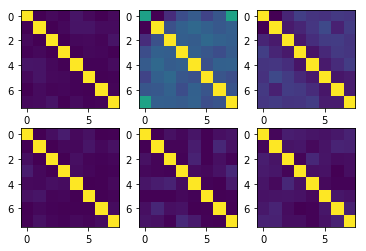

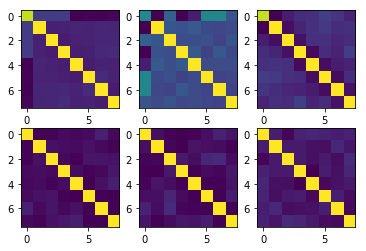

In [34]:
# fig, axes = plt.subplots(2, 3)

plt.figure(1)
plt.subplot(2, 3, 1)
plt.imshow(im_sep["DG"])
plt.subplot(2, 3, 2)
plt.imshow(im_sep["CA3"])
plt.subplot(2, 3, 3)
plt.imshow(im_sep["CA1"])

plt.subplot(2, 3, 4)
plt.imshow(fm_sep["DG"])
plt.subplot(2, 3, 5)
plt.imshow(fm_sep["CA3"])
plt.subplot(2, 3, 6)
plt.imshow(fm_sep["CA1"])

plt.figure(2)
plt.subplot(2, 3, 1)
plt.imshow(im_seq["DG"])
plt.subplot(2, 3, 2)
plt.imshow(im_seq["CA3"])
plt.subplot(2, 3, 3)
plt.imshow(im_seq["CA1"])

plt.subplot(2, 3, 4)
plt.imshow(fm_seq["DG"])
plt.subplot(2, 3, 5)
plt.imshow(fm_seq["CA3"])
plt.subplot(2, 3, 6)
plt.imshow(fm_seq["CA1"])

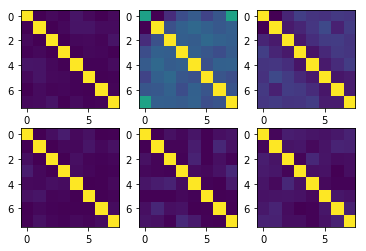

In [33]:
# fig, axes = plt.subplots(2, 3)



In [ ]:
float("nan") == float("nan")